**Part 1: MultiModal Chatbot System**



INSTALLATIONS

In [ ]:
!pip install openai

In [ ]:
!pip install -q transformers==4.42.3
!pip install -q accelerate==0.31.0
!pip install -q bitsandbytes==0.45.3
!pip install -q peft==0.11.1
!pip install -q triton
!pip install -q chromadb sentence-transformers \
                evaluate bert_score rouge_score scikit-learn pandas PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 115.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have nump

In [ ]:
!pip -q install rank-bm25 sentence-transformers

In [ ]:
!apt-get install -y poppler-utils tesseract-ocr
!pip install "unstructured[all-docs]" pillow nltk


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.12 [186 kB]
Fetched 186 kB in 2s (119 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.12_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.12) ...
Setting up poppler-utils (22.02.0-2ubuntu0.12) ...
Processing triggers for man-db (2.10.2-1) ...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 62.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


SETUP AND PATHS

In [ ]:
from google.colab import drive
import os

# mounting the drive
drive.mount('/content/drive')

# directories
BASE_DIR = "/content/drive/MyDrive/Lab2-hyp"
DATA_DIR = os.path.join(BASE_DIR, "data")
OUTPUT_DIR = os.path.join(BASE_DIR, "pdf_outputs")
MODEL_DIR = os.path.join(BASE_DIR, "models")
CHROMA_DIR = os.path.join(BASE_DIR, "chroma_store")

for d in [DATA_DIR, OUTPUT_DIR, MODEL_DIR, CHROMA_DIR]:
    os.makedirs(d, exist_ok=True)

PDF_PATH = os.path.join(DATA_DIR, "WHO_document.pdf")

print(f"DATA_DIR:   {DATA_DIR}")
print(f"OUTPUT_DIR: {OUTPUT_DIR}")
print(f"CHROMA_DIR: {CHROMA_DIR}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
DATA_DIR:   /content/drive/MyDrive/Lab2-hyp/data
OUTPUT_DIR: /content/drive/MyDrive/Lab2-hyp/pdf_outputs
CHROMA_DIR: /content/drive/MyDrive/Lab2-hyp/chroma_store


IMPORTS / OPEN AI SET UP

In [ ]:
import torch, os, json, re, fitz, nltk, chromadb
import numpy as np
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from google.colab import userdata
from openai import OpenAI

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# sentence tokenizer
nltk.download("punkt_tab", quiet=True)

# OpenAI client
OPENAI_API_KEY = userdata.get("OPENAI_API_KEY")
client_oa = OpenAI(api_key=OPENAI_API_KEY)
print("OpenAI client ready.")


Device: cuda
OpenAI client ready.


### **Data Processing & Storage**

Parse PDF (text + figures/tables) with Unstructured IO ---> Experimented with this library to extract the items effeciently. This helped to improve scores.

In [ ]:
# Parse PDF
import os, re, json, fitz
from nltk.tokenize import sent_tokenize
from unstructured.partition.pdf import partition_pdf

# to remove unknown chars
def clean_extracted_text(text: str) -> str:
    text = (text or "").replace("â€“", "–").replace("â€", "–").replace("â€\\“", "–").replace("â€\\”", "–")
    text = re.sub(r"\s+", " ", text).strip()
    return text

# figure patterns
FIG_PATTERN = re.compile(r"^(?:Figure|Fig|FIGURE|FIG)\.?\s*(\d+(?:\.\d+)*)\s*[:\-–]?\s*", re.IGNORECASE)
IGNORE_FIG_REF = re.compile(r"^(?:Figure|Fig|FIGURE|FIG)\.?\s*\d+(?:\.\d+)*\s+shows\b.*",re.IGNORECASE)
TBL_PATTERN = re.compile(r"^(?:Table|TABLE)\.?\s*(\d+(?:\.\d+)*)\s*[:\-–]?\s*", re.IGNORECASE)

# pdf parsing
def parse_document(pdf_path, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    IMAGE_DIR = os.path.join(output_dir, "images")
    os.makedirs(IMAGE_DIR, exist_ok=True)

    text_json = os.path.join(output_dir, "text_chunks.json")
    caps_json = os.path.join(output_dir, "figure_captions.json")
    fmap_json  = os.path.join(output_dir, "figure_image_map.json")


    all_text_blocks, figure_captions, figure_image_map = [], [], {}
    sid = 0

    print(f"Processing file: {pdf_path}")


    # Parse PDF using Unstructured ----> this is how we extract the contents from pdf
    elements = partition_pdf(
        filename=pdf_path,
        strategy="hi_res",
        extract_images_in_pdf=True,
        extract_image_block_types=["Image"],
        extract_image_block_output_dir=IMAGE_DIR,
        infer_table_structure=True,
        include_page_breaks=True
    )

    image_iter = 1
    # text + caption extraction
    for el in elements:
        text = getattr(el, "text", "").strip()
        if not text:
            continue

        text = clean_extracted_text(text)
        metadata = getattr(el, "metadata", None)
        page_num = getattr(metadata, "page_number", None) or 0

        fig_match = FIG_PATTERN.match(text)
        tbl_match = TBL_PATTERN.match(text)

        if IGNORE_FIG_REF.match(text):
          continue

        elif fig_match or tbl_match:
            kind = "figure" if fig_match else "table"
            number = (fig_match or tbl_match).group(1)
            cap_id = f"{kind}_{number}"
            block_id = f"p{page_num}_b{sid}"
            fig_path = os.path.join(IMAGE_DIR,f"figure-{page_num}-{image_iter}.jpg")

            figure_captions.append({
                "id": cap_id,
                "img_path": fig_path,
                "caption": text,
                "figure_number": number,
                "page": page_num,
                "block_id": block_id
            })

            figure_image_map[cap_id] = fig_path

            image_iter += 1
            if image_iter == 9:
              image_iter = 12

            all_text_blocks.append({
                "id": f"sent_{sid}",
                "content": text,
                "page": page_num,
                "block_id": block_id
            })
            sid += 1

        else:
            block_id = f"p{page_num}_b{sid}"
            for sent in sent_tokenize(text):
                sent = sent.strip()
                if len(sent) < 10:
                    continue
                all_text_blocks.append({
                    "id": f"sent_{sid}",
                    "content": sent,
                    "page": page_num,
                    "block_id": block_id
                })
                sid += 1

    # Save JSONs files

    with open(text_json, "w", encoding="utf-8") as f:
        json.dump(all_text_blocks, f, indent=2, ensure_ascii=False)
    with open(caps_json, "w", encoding="utf-8") as f:
        json.dump(figure_captions, f, indent=2, ensure_ascii=False)
    with open(fmap_json, "w", encoding="utf-8") as f:
        json.dump(figure_image_map, f, indent=2, ensure_ascii=False)


    print(f"\nParsed {len(all_text_blocks)} text chunks")
    print(f"Extracted {len(figure_captions)} figure/table captions")
    print(f"Saved figure-image map: {len(figure_image_map)} entries")
    print(f"OUTPUT_DIR: {OUTPUT_DIR}")


    return all_text_blocks, figure_captions, figure_image_map


# Example call
_ = parse_document(PDF_PATH, OUTPUT_DIR)


Processing file: /content/drive/MyDrive/Lab2-hyp/data/WHO_document.pdf

Parsed 905 text chunks
Extracted 30 figure/table captions
Saved figure-image map: 30 entries
OUTPUT_DIR: /content/drive/MyDrive/Lab2-hyp/pdf_outputs


SAMPLE DATA   ----> The extracted image looks like below:

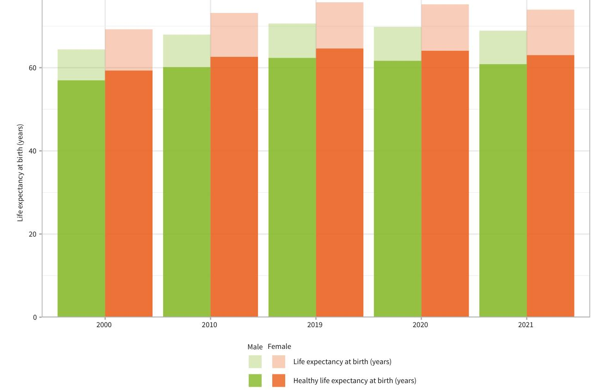

In [ ]:
from PIL import Image
from IPython.display import display

img_path = "/content/drive/MyDrive/Lab2-hyp/pdf_outputs/images/figure-1-1.jpg"
img = Image.open(img_path)

# Resize
base_width = 600
wpercent = base_width / float(img.size[0])
hsize = int(float(img.size[1]) * wpercent)
img_resized = img.resize((base_width, hsize))

display(img_resized)

THIS IS HOW SAMPLE TEXT CHUNK LOOK LIKE:

In [ ]:
import json
import pandas as pd
import os

text_json = os.path.join(OUTPUT_DIR, "text_chunks.json")

with open(text_json, "r", encoding="utf-8") as f:
    text_chunks = json.load(f)

# show first few
for i, chunk in enumerate(text_chunks[:5]):
    print(f"ID: {chunk['id']} | Page: {chunk['page']}")
    print(chunk["content"])
    print("-" * 120)


ID: sent_0 | Page: 1
World health statistics 2024: monitoring health for the SDGs, Sustainable Development Goals
------------------------------------------------------------------------------------------------------------------------
ID: sent_1 | Page: 1
1.1 Life expectancy and healthy life expectancy
------------------------------------------------------------------------------------------------------------------------
ID: sent_2 | Page: 1
1.1.1 Global trend
------------------------------------------------------------------------------------------------------------------------
ID: sent_3 | Page: 1
Steady gain in global life expectancy at birth was observed from the turn of the millennium until the onset of the COVID-19 pandemic, up from 66.8 years (95% uncertainty interval1 [UI]: 66.2–67.3 years) in 2000 to 73.1 (UI: 72.6–73.7) years in 2019, with men gaining 6.2 years from 64.4 (UI: 63.9–64.9) years to 70.6 (UI
-------------------------------------------------------------------------

INITIALIZING CHROMA DB

In [ ]:
import os, shutil, chromadb

# local
CHROMA_DIR = "/content/chroma_store_fresh7"
COLLECTION_NAME = "who_unified_embeddings"

if os.path.exists(CHROMA_DIR):
    shutil.rmtree(CHROMA_DIR)
os.makedirs(CHROMA_DIR, exist_ok=True)

print("Created new local Chroma directory:", CHROMA_DIR)

# recreate client
client = chromadb.PersistentClient(path=CHROMA_DIR)
collection = client.get_or_create_collection(COLLECTION_NAME)

Created new local Chroma directory: /content/chroma_store_fresh7


LOADING PARSED OUTPUTS

In [ ]:
CHROMA_DIR = "/content/chroma_store_fresh7"
TEXT_JSON   = os.path.join(OUTPUT_DIR, "text_chunks.json")
CAP_JSON    = os.path.join(OUTPUT_DIR, "figure_captions.json")
IMG_MAP_JSON= os.path.join(OUTPUT_DIR, "figure_image_map.json")
IMG_DIR     = os.path.join(OUTPUT_DIR, "images")

with open(TEXT_JSON, "r") as f:         text_chunks = json.load(f)
with open(CAP_JSON, "r") as f:          figure_captions = json.load(f)
with open(IMG_MAP_JSON, "r") as f:      figure_image_map = json.load(f)

print(f"Loaded {len(text_chunks)} text chunks, {len(figure_captions)} captions.")
print(f"Image dir: {IMG_DIR}, mappings: {len(figure_image_map)}")

Loaded 905 text chunks, 30 captions.
Image dir: /content/drive/MyDrive/Lab2-hyp/pdf_outputs/images, mappings: 30


CHROMA SETUP

In [ ]:
# CHROMA SETUP

import chromadb
from tqdm import tqdm

COLL_TEXT = "who_text_figure_3072_new"
COLL_IMG  = "who_image_512_new"

chroma = chromadb.PersistentClient(path=CHROMA_DIR)
col_text = chroma.get_or_create_collection(COLL_TEXT)  # 3072-dim
col_img  = chroma.get_or_create_collection(COLL_IMG)   # 512-dim

print("Chroma ready:", CHROMA_DIR)

Chroma ready: /content/chroma_store_fresh7


STORING THE EMBEDDINGS

In [ ]:
# INDEX TEXT + CAPTIONS (3072) dim

TEXT_EMB_MODEL = "text-embedding-3-large"

def embed_openai(texts, batch=100):
    vecs = []
    for i in tqdm(range(0, len(texts), batch)):
        chunk = texts[i:i+batch]
        resp = client_oa.embeddings.create(model=TEXT_EMB_MODEL, input=chunk)
        vecs.extend([d.embedding for d in resp.data])
    return vecs

# Text chunks
text_docs = [t["content"] for t in text_chunks]
text_metas = [{"type": "text", "page": t["page"], "block_id": t["block_id"]} for t in text_chunks]
text_ids   = [f"text_{i}" for i in range(len(text_docs))]

if text_docs:
    print("Indexing text chunks ...")
    text_vecs = embed_openai(text_docs, batch=120)
    col_text.add(ids=text_ids, embeddings=text_vecs, documents=text_docs, metadatas=text_metas)
    print(f"Indexed {len(text_docs)} text chunks into {COLL_TEXT}.")

# Figure/Table captions
def ensure_fig_num(meta):
    if meta.get("figure_number"): return str(meta["figure_number"]).strip()
    if meta.get("id"):
        m = re.search(r"(\d+(?:\.\d+)*)", meta["id"])
        if m: return m.group(1)
    if meta.get("caption"):
        m = re.search(r"(?:Figure|Fig\.?|Table)\s+(\d+(?:\.\d+)*)", meta["caption"], flags=re.I)
        if m: return m.group(1)
    return None

cap_docs  = [c["caption"] for c in figure_captions]
cap_metas = []
for c in figure_captions:
    cap_metas.append({
        "type": c.get("kind", "figure"),
        "page": c.get("page"),
        "figure_id": c.get("id"),
        "figure_number": ensure_fig_num(c),

    })
cap_ids = [f"cap_{i}" for i in range(len(cap_docs))]

if cap_docs:
    print("Indexing captions ...")
    cap_vecs = embed_openai(cap_docs, batch=100)
    col_text.add(ids=cap_ids, embeddings=cap_vecs, documents=cap_docs, metadatas=cap_metas)
    print(f"Indexed {len(cap_docs)} captions into {COLL_TEXT}.")


Indexing text chunks ...


100%|██████████| 8/8 [00:16<00:00,  2.02s/it]


Indexed 905 text chunks into who_text_figure_3072_new.
Indexing captions ...


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

Indexed 30 captions into who_text_figure_3072_new.


In [ ]:
# INDEX IMAGES (512, CLIP)

from PIL import Image
from sentence_transformers import SentenceTransformer
import numpy as np

clip = SentenceTransformer("clip-ViT-B-32")

# Only images that exist on disk
image_files = []
for fig_id, path in figure_image_map.items():
    if isinstance(path, str) and os.path.exists(path):
        image_files.append((fig_id, path))

print(f"Found {len(image_files)} physical images for embedding.")

img_ids, img_docs, img_metas, img_vecs = [], [], [], []
for idx, (fig_id, path) in enumerate(tqdm(image_files)):
    try:
        emb = clip.encode(Image.open(path).convert("RGB"), convert_to_numpy=True, normalize_embeddings=True)
        img_vecs.append(emb.tolist())
        img_ids.append(f"img_{idx}")
        img_docs.append("(image)")

        m = re.search(r"(\d+(?:\.\d+)*)", fig_id)
        fig_num = m.group(1) if m else None
        img_metas.append({
            "type": "image",
            "figure_id": fig_id,
            "figure_number": fig_num,
            "image_path": path
        })
    except Exception as e:
        print("Skip:", fig_id, path, "->", e)

if img_vecs:
    col_img.add(ids=img_ids, embeddings=img_vecs, documents=img_docs, metadatas=img_metas)
    print(f"Indexed {len(img_vecs)} images into {COLL_IMG}.")
else:
    print("No image embeddings added.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Found 30 physical images for embedding.


100%|██████████| 30/30 [00:22<00:00,  1.35it/s]

Indexed 30 images into who_image_512_new.


In [ ]:
from PIL import Image
from sentence_transformers import SentenceTransformer

clip = SentenceTransformer("clip-ViT-B-32")

sample = Image.open("/content/drive/MyDrive/Lab2-hyp/pdf_outputs/images/figure-1-1.jpg").convert("RGB")
emb = clip.encode(sample, normalize_embeddings=True)
print("Vector shape:", emb.shape)


Vector shape: (512,)


## **Retrieval System with Context Awareness**

In [ ]:
TEXT_EMB_MODEL = "text-embedding-3-large"

In [ ]:
# RETRIEVAL UTILS

from rank_bm25 import BM25Okapi
import numpy as np

def contextual_reformulate(query, history, keep_last=3):
    ctx = " ".join([m["content"] for m in history[-keep_last*2:] if isinstance(m, dict) and m.get("role")=="user"])
    return f"Context: {ctx}. Question: {query}" if ctx else query

# --- Dense text retrieval (3072) ---
def dense_text(query, top_k=20):
    q = client_oa.embeddings.create(model=TEXT_EMB_MODEL, input=[query]).data[0].embedding
    res = col_text.query(query_embeddings=[q], n_results=top_k)
    docs, metas, dists = res["documents"][0], res["metadatas"][0], res["distances"][0]
    return [{"text": d, "meta": m, "score": 1.0 - dist} for d,m,dist in zip(docs, metas, dists)]

# --- Sparse BM25 over parsed text chunks only (fast keyword recall) ---
bm25 = BM25Okapi([re.findall(r"\w+", t["content"].lower()) for t in text_chunks])
def sparse_text(query, top_k=20):
    toks = re.findall(r"\w+", query.lower())
    scores = bm25.get_scores(toks)
    idxs = np.argsort(scores)[::-1][:top_k]
    out = []
    for i in idxs:
        t = text_chunks[i]
        out.append({"text": t["content"], "meta": {"type":"text","page":t["page"],"block_id":t["block_id"]}, "score": float(scores[i])})
    return out

# --- Hybrid fuse dense+sparse ---
def hybrid_text(query, alpha=0.7, top_k=30):
    d = dense_text(query, top_k)
    s = sparse_text(query, top_k)
    if not d: return s[:top_k]
    maxd = max(r["score"] for r in d) or 1.0
    maxs = max([r["score"] for r in s] or [1.0])
    ds = {r["text"]: r["score"]/maxd for r in d}
    ss = {r["text"]: r["score"]/maxs for r in s}
    combined = {t: alpha*ds.get(t,0)+(1-alpha)*ss.get(t,0) for t in set(ds)|set(ss)}
    ranked = sorted(
        [{"text":t,"score":sc,"page":next((r["meta"].get("page") for r in d if r["text"]==t), None),"type":"text"} for t,sc in combined.items()],
        key=lambda x:x["score"], reverse=True
    )
    return ranked[:top_k]

# --- Caption retrieval (figures/tables) from text collection (3072) ---
def top_captions(query, top_k=3):
    q = client_oa.embeddings.create(model=TEXT_EMB_MODEL, input=[f"{query} figure chart table"]).data[0].embedding
    res = col_text.query(query_embeddings=[q], n_results=top_k*5)
    out=[]
    for d,m in zip(res["documents"][0], res["metadatas"][0]):
        if m.get("type") in ("figure","table"):
            # recover fig number
            fig_num = m.get("figure_number")
            if not fig_num:
                mo = re.search(r"(\d+(?:\.\d+)*)", str(m.get("figure_id","")))
                fig_num = mo.group(1) if mo else None
            out.append({"caption": d, "page": m.get("page"), "type": m.get("type"), "figure_number": fig_num})
        if len(out) >= top_k: break
    return out

# --- Image retrieval (512/CLIP) ---
from sentence_transformers import SentenceTransformer
clip_text = SentenceTransformer("clip-ViT-B-32")

def top_images(query, top_k=3):
    qv = clip_text.encode([query], normalize_embeddings=True)
    res = col_img.query(query_embeddings=qv.tolist(), n_results=top_k)
    imgs=[]
    for m in res["metadatas"][0]:
        imgs.append({"type":"image","figure_number": m.get("figure_number"), "image_path": m.get("image_path")})
    return imgs

# --- Unified retrieval with conversation context ---
def retrieve_with_context(user_query, history, top_text=5, top_visual=3, top_imgs=3):
    reformulated = contextual_reformulate(user_query, history)
    texts   = hybrid_text(reformulated, top_k=max(30, top_text*6))[:top_text]
    captions= top_captions(reformulated, top_k=top_visual)
    images  = top_images(reformulated,   top_k=top_imgs)
    return {"query": reformulated, "texts": texts, "visuals": captions, "images": images}


## **Conversational Response Generation**

LLM Answer Generation

In [ ]:
# LLM Answer Generation (Multimodal-Aware)

GEN_MODEL = "gpt-4-turbo"

# ---- Intent detection --------------------------------------------------------
def detect_intent(user_query: str) -> str:
    q = user_query.lower()
    if any(k in q for k in ["figure", "table", "show", "visual", "chart", "graph"]):
        return "visual"
    if any(k in q for k in ["compare", "trend", "increase", "decrease", "difference"]):
        return "analytical"
    if any(k in q for k in ["why", "how", "reason", "explain"]):
        return "reasoning"
    return "general"


# ---- Build full multimodal context ------------------------------------------
def build_context_blocks(retrieval_result):
    # ---- Text context ----
    text_lines, seen = [], set()
    for t in retrieval_result.get("texts", []):
        key = (t.get("page"), t.get("text"))
        if key in seen:
            continue
        seen.add(key)
        text_lines.append(f"(Page {t.get('page')}) {t['text']}")
    text_block = "\n".join(text_lines)

    # ---- Figure/Table captions ----
    visual_lines, visual_refs = [], []
    for v in retrieval_result.get("visuals", []):
        num = v.get("figure_number")
        tag = (
            f"Figure {num}" if (v.get("type") == "figure" and num)
            else f"Table {num}" if (v.get("type") == "table" and num)
            else v.get("type", "Figure").capitalize()
        )
        img_path = v.get("image_path") or "missing"
        visual_lines.append(f"{tag} (Page {v.get('page')}): {v.get('caption')}")
        visual_refs.append({"figure_number": num, "path": img_path})
    visual_block = "\n".join(visual_lines)

    # ---- Actual images retrieved via CLIP ----
    image_lines, image_refs = [], []
    for im in retrieval_result.get("images", []):
        num = im.get("figure_number")
        path = im.get("image_path") or "missing"
        image_lines.append(f"Image for Figure {num}: {path}")
        image_refs.append({"figure_number": num, "path": path})
    image_block = "\n".join(image_lines)

    return {
        "text_block": text_block,
        "visual_block": visual_block,
        "image_block": image_block,
        "visual_refs": visual_refs,
        "image_refs": image_refs,
    }


# ---- Cleaner text utility ---------------------------------------------------
import re
def clean_answer_text(text: str) -> str:
    """Normalize LLM answers before saving to CSV."""
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\*\*(.*?)\*\*", r"\1", text)
    text = re.sub(r"\*(.*?)\*", r"\1", text)
    text = re.sub(r"__([^_]+)__", r"\1", text)
    text = re.sub(r"\(page.*?\)", "", text, flags=re.I)
    text = re.sub(r"\(figure.*?\)", "", text, flags=re.I)
    text = re.sub(r"see\s*figure\s*\d+(\.\d+)*", "", text, flags=re.I)
    text = re.sub(r"â€“|â€”", "-", text)
    text = text.replace("’", "'").replace("‘", "'")
    text = re.sub(r"[^a-zA-Z0-9.,:;!?%()\s'\-]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


# ---- Main generator ---------------------------------------------------------
def generate_llm_reply(user_query: str, retrieval_result, memory, fact_check=True):
    """
    Generate concise WHO-style answers (2 factual sentences) that reuse
    wording and numbers directly from WHO text and reference visuals/images.
    """
    intent = detect_intent(user_query)
    blocks = build_context_blocks(retrieval_result)

    # Few-shot examples (keep same style)
    few_shots = """
Example 1
Q: What happened to global life expectancy during the COVID-19 pandemic?
A: Global life expectancy dropped from 73.1 years in 2019 to 71.4 years in 2021, and HALE fell from 63.5 to 61.9 years (Figure 1.1).

Example 2
Q: What were the top causes of death globally in 2021?
A: The leading causes of death worldwide were ischaemic heart disease, COVID-19, stroke, chronic obstructive pulmonary disease and lower respiratory infections (Figures 1.7 and 1.8).
"""

    # --- System prompt --------------------------------------------------------
    system_prompt = f"""
You are a WHO data summarizer.
Copy WHO wording, numbers, and spellings directly from the provided text.

{few_shots}

Rules:
- Answer in exactly TWO to THREE short factual sentences (≤60 words total).
- Speak conversationally, not like a report.
- Use different phrases with same meaning
- If the user's question is vague, ask a short, polite clarifying question.
- Reference relevant figures or tables smoothly (e.g., "According to Figure 2.2, ...").
- You may refer to earlier messages if related (use memory).
- Always stay factual and concise.
- If the user asks about trends or comparisons, mention direction and magnitude.
- Use wording, numbers, and years exactly as in WHO text.
- When a figure or table is relevant, clearly describe its key findings
  (e.g., list main causes, trends, or data values) rather than saying "Figure X shows".
- If actual images are retrieved, reference them explicitly (e.g., "see corresponding image for Figure X") when relevant.
- Ensure both sentences are grammatically complete and end with punctuation.
- Never include 'Page' references or speculation.
- Be direct, declarative, and professional.
- For figures, say like "According to figure"
- Cite figures naturally (")
Intent: {intent}
"""

    # --- User payload --------------------------------------------------------
    user_payload = f"""
Question: {user_query}

Relevant WHO text:
{blocks['text_block']}

Relevant figure/table captions:
{blocks['visual_block']}

Relevant images:
{blocks['image_block']}

Write two short factual sentences in WHO wording.
Each sentence must be complete and end with a period.
"""

    # --- Memory management ----------------------------------------------------
    safe_memory = [m for m in (memory or []) if isinstance(m, dict) and "role" in m and "content" in m]
    messages = (
        [{"role": "system", "content": system_prompt}]
        + safe_memory
        + [{"role": "user", "content": user_payload}]
    )

    # --- Model call -----------------------------------------------------------
    resp = client_oa.chat.completions.create(
        model=GEN_MODEL,
        messages=messages,
        temperature=0.1,
        top_p=0.9,
        max_tokens=600,
    )

    reply = resp.choices[0].message.content.strip()
    # Basic cleanup
    reply = re.sub(r"\s+([.,!?;:])", r"\1", reply)
    reply = re.sub(r"\(\s+", "(", reply)
    reply = re.sub(r"\s+\)", ")", reply)
    reply = re.sub(r"\s+", " ", reply).strip()
    if not reply.endswith(('.', '!', '?')):
        reply += "."

    # Normalize spellings
    normalize_map = {
        "ischemic": "ischaemic",
        "covid 19": "COVID-19",
        "copd": "chronic obstructive pulmonary disease",
        "respiratory infections": "lower respiratory infections",
    }
    for k, v in normalize_map.items():
        reply = re.sub(k, v, reply, flags=re.I)

    # Trim to two sentences
    sentences = re.split(r'(?<=[.!?])\s+', reply)
    reply = " ".join(sentences[:2]).strip()
    if len(reply.split()) > 50:
        reply = " ".join(reply.split()[:50])
    if not reply.endswith(('.', '!', '?')):
        reply += '.'

    # Final punctuation normalization
    reply = re.sub(r"\s+([.,!?;:])", r"\1", reply)
    reply = re.sub(r"\(\s+", "(", reply)
    reply = re.sub(r"\s+\)", ")", reply)
    reply = re.sub(r"\s+", " ", reply).strip()

    memory.append({"role": "user", "content": user_query})
    memory.append({"role": "assistant", "content": reply})
    if len(memory) > 10:
        del memory[:-10]

      # --- Conversational citation rewrite -------------------------------------

    reply = re.sub(
        r"\(?\b[Ff]igure\s+(\d+(?:\.\d+)*)\)?",
        r"According to Figure \1,",
        reply
    )

    # If multiple figure references appear, keep only the first one conversational
    reply = re.sub(r"(According to Figure [\d\.]+,.*?)(According to Figure [\d\.]+,)", r"\1Figure ", reply)

    if not re.search(r"According to Figure", reply):
      reply = re.sub(r"\(?\b[Ff]igure\s+(\d+(?:\.\d+)*)\)?", r"According to Figure \1,", reply)


    # Return answer
    return reply


In [ ]:
#  Auto-Generate Submission (multimodal-aware)

import uuid
from datetime import datetime
import pandas as pd
import os, re, shutil

# Create a unique inference folder -------------------------------
base_inference_dir = os.path.join(OUTPUT_DIR, "inference")
n = 1
while True:
    INFERENCE_DIR = f"{base_inference_dir}_{n:03d}"
    if not os.path.exists(INFERENCE_DIR):
        os.makedirs(INFERENCE_DIR)
        break
    n += 1
print(f"Inference images will be saved to: {INFERENCE_DIR}")

# Load official question file -----------------------------------
QUESTIONS_CSV = os.path.join(DATA_DIR, "266_lab2_questions.csv")
questions_df = pd.read_csv(QUESTIONS_CSV)
print(f"Loaded {len(questions_df)} questions from {QUESTIONS_CSV}")

# Initialize memory & containers --------------------------------
conversation_history = []
submission_rows = []

# Helper: extract figure numbers from text ----------------------------
def extract_figure_numbers_from_text(text):
    return sorted(set(re.findall(r"(?:Figure|Fig\.?|Table)\s+(\d+(?:\.\d+)*)", str(text), flags=re.I)))

def keyword_overlap(a, b):
    a_tokens = set(re.findall(r"\w+", str(a).lower()))
    b_tokens = set(re.findall(r"\w+", str(b).lower()))
    return len(a_tokens & b_tokens) > 0

# Loop through questions ----------------------------------------
for idx, row in questions_df.iterrows():
    q_id = row.get("id")
    conversation_id = row.get("conversation_id")
    question_id = row.get("question_id")
    user_query = str(row.get("question") or row.get("Question") or row[0]).strip()

    print(f"\nProcessing Conversation {conversation_id}, Q{question_id}: {user_query}")

    # --- Retrieve multimodal context (text + visuals + images)
    retrieval = retrieve_with_context(
    user_query,
    conversation_history,
    top_text=5,
    top_visual=3,
    top_imgs=3
)



    # --- Generate model answer
    answer = generate_llm_reply(user_query, retrieval, conversation_history)
    answer = re.sub(r"[\n\r]+", " ", answer)
    answer = re.sub(r"\b(however|overall|moreover|in summary|according to)\b","",answer,flags=re.I)

    answer = re.sub(r"\b(\w+)\s+\1\b", r"\1", answer)  # remove repeated words
    answer = re.sub(r"([,.;!?]){2,}", r"\1", answer)
    answer = re.sub(r"\s+([,.;!?])", r"\1", answer)

    answer = re.sub(r"\s+", " ", answer).strip()
    if len(answer.split()) > 100:                # was 85
      words = answer.split()
      answer = " ".join(words[:100])
      answer = re.sub(r"\s+(and|or|with|by|at|to)$", "", answer.strip())  # end cleanly
      if not answer.endswith('.'):
        answer += '.'

   # -- Determine which figures to keep --------------------------------

    # Figures explicitly mentioned in the LLM answer
    mentioned_figs = set(extract_figure_numbers_from_text(answer))

    # Retrieved figures (from captions)
    retrieved_visuals = retrieval.get("visuals", [])
    retrieved_imgs    = retrieval.get("images", [])

    # Start with figures mentioned by the model
    relevant_figs = set(mentioned_figs)

    # If none explicitly cited, take top 2 most relevant retrieved visuals
    if not relevant_figs and retrieved_visuals:
        top_visuals = [
            v.get("figure_number") for v in retrieved_visuals[:3]
            if v.get("figure_number")
        ]
        if top_visuals:
            relevant_figs = set(top_visuals)

    # Sort and clean
    fig_nums = sorted(
        [f for f in relevant_figs if f],
        key=lambda x: tuple(map(int, x.split("."))) if x else (999,)
    ) or ["0"]


    # --- Save referenced images to inference folder -----------------
# --- Save only images explicitly in figure_references -------------
    saved = set()

    # We only care about the figures in fig_nums (the final references)
    for fnum in fig_nums:
        if not fnum or fnum == "0":
            continue

        # (A) Try CLIP-retrieved image collection
        match = next((img for img in retrieved_imgs if img.get("figure_number") == fnum), None)
        if match and os.path.exists(match.get("image_path", "")):
            src = match["image_path"]
            dst = os.path.join(INFERENCE_DIR, f"conv{conversation_id}_q{question_id}_fig{fnum}.png")
            try:
                shutil.copy(src, dst)
                saved.add(fnum)
                #print(f"Saved CLIP image for Figure {fnum} → {dst}")
                continue
            except Exception as e:
                print(f"Warning: could not copy {src}: {e}")

        # Try caption-linked visual entry
        match = next((v for v in retrieved_visuals if v.get("figure_number") == fnum), None)
        if match and os.path.exists(match.get("image_path", "")):
            src = match["image_path"]
            dst = os.path.join(INFERENCE_DIR, f"conv{conversation_id}_q{question_id}_fig{fnum}.png")
            try:
                shutil.copy(src, dst)
                saved.add(fnum)
                #print(f"Saved caption image for Figure {fnum} → {dst}")
                continue
            except Exception as e:
                print(f"Warning: could not copy {src}: {e}")

        # (C) Fallback: use figure_image_map
        fid = f"figure_{fnum}"
        src = figure_image_map.get(fid)
        if src and os.path.exists(src):
            dst = os.path.join(INFERENCE_DIR, f"conv{conversation_id}_q{question_id}_fig{fnum}.png")
            try:
                shutil.copy(src, dst)
                saved.add(fnum)
                #print(f"Saved fallback image for Figure {fnum} → {dst}")
            except Exception as e:
                print(f"Warning: could not copy {src}: {e}")


    # --- Append to submission rows ----------------------------------
    submission_rows.append({
        "id": q_id,
        "conversation_id": conversation_id,
        "question_id": question_id,
        "question": user_query,
        "answer": answer,
        "figure_references": ", ".join(fig_nums)
    })

    # --- Maintain conversation memory ------------------------------------
    conversation_history.append({"role": "user", "content": user_query})
    conversation_history.append({"role": "assistant", "content": answer})

# --- Save submission CSV ---------------------------------------------
submission_df = pd.DataFrame(submission_rows)
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
SUBMISSION_PATH = os.path.join(OUTPUT_DIR, f"submission_{timestamp}.csv")

submission_df["figure_references"] = (
    submission_df["figure_references"]
      .astype(str)
      .str.replace(r"\s+", "", regex=True)
      .str.strip(",")
      .replace("", "0")
)

submission_df.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8")

print(f"\n Submission saved → {SUBMISSION_PATH}")
print(f" Inference images saved in folder → {INFERENCE_DIR}")
#print(f"Total images copied: {len(os.listdir(INFERENCE_DIR))}")



Inference images will be saved to: /content/drive/MyDrive/Lab2-hyp/pdf_outputs/inference_031
Loaded 14 questions from /content/drive/MyDrive/Lab2-hyp/data/266_lab2_questions.csv

Processing Conversation 1, Q1: What happened to global life expectancy during the COVID-19 pandemic?

Processing Conversation 1, Q2: Which regions were hit hardest by the pandemic?

Processing Conversation 1, Q3: How did the disease burden shift during this time?

Processing Conversation 2, Q1: What were the top causes of death globally in 2021?

Processing Conversation 2, Q2: Did COVID-19 rank differently across regions?

Processing Conversation 2, Q3: What about child and maternal mortality during this period?

Processing Conversation 3, Q1: How is the world doing on HIV prevention?

Processing Conversation 3, Q2: What about other infectious diseases like TB and malaria?

Processing Conversation 3, Q3: Are there any success stories in disease elimination?

Processing Conversation 4, Q1: What's the status of 

In [9]:
pd.set_option("display.max_colwidth", None)
display(submission_df.head(15))

,id,conversation_id,question_id,question,answer,figure_references
0,1,1,1,What happened to global life expectancy during the COVID-19 pandemic?,"Global life expectancy at birth dropped from 73.1 years in 2019 to 71.4 years in 2021, reversing nearly a decade of progress in just two years. Similarly, global healthy life expectancy (HALE) decreased from 63.5 years in 2019 to 61.9 years in 2021.",1.3
1,2,1,2,Which regions were hit hardest by the pandemic?,"The Region of the Americas and the South-East Asia Region were the hardest hit by the pandemic, with life expectancy dropping by 3.0 years and HALE by 2.5 years between 2019 and 2021. In contrast, the Western Pacific Region experienced the least impact, with minimal losses in life expectancy.",0
2,3,1,3,How did the disease burden shift during this time?,"During the COVID-19 pandemic, there was a notable shift in the global disease burden, with a resurgence of communicable diseases. Figure 1.4, the share of deaths from communicable diseases increased from 18.2% in 2019 to 28.1% in 2021, while deaths from noncommunicable diseases decreased from 73.9% to 65.3%.","1.4,1.5,1.7"
3,4,2,1,What were the top causes of death globally in 2021?,"The leading causes of death worldwide in 2021 were ischaemic heart disease, COVID-19, stroke, chronic obstructive pulmonary disease, and lower respiratory infections. This information is detailed in Figure 1.7, which illustrates the top 10 causes of death globally for the years 2000, 2019, 2020, and 2021.",1.7
4,5,2,2,Did COVID-19 rank differently across regions?,"COVID-19 ranked differently across regions, being the leading cause of death in the Region of the Americas and the South-East Asia Region in 2021, and the second leading cause in the European and Eastern Mediterranean regions in both 2020 and 2021. In the African Region, COVID-19 moved up from the.",0
5,6,2,3,What about child and maternal mortality during this period?,"Maternal and child mortality have seen significant global reductions since 2000, with the maternal mortality ratio dropping by a third from 339 deaths per 100,000 live births in 2000 to 227 in 2015, and under-five mortality rate declining by 51% from 76 deaths per 1,000 live births in 2000 to.","1.1,1.2,1.12"
6,7,3,1,How is the world doing on HIV prevention?,"At the end of 2022, there were an estimated 39.0 million people living with HIV globally, with 1.3 million new HIV infections occurring that year. This represents a 54% reduction in new infections from 2000, and a 27% reduction from 2015, indicating significant progress in HIV prevention efforts globally.","2.1,2.5,2.8"
7,8,3,2,What about other infectious diseases like TB and malaria?,"The global TB incidence rate saw an 8.7% reduction from 2015 to 2022, but this is significantly behind the WHO End TB strategy milestone of a 50% reduction by 2025. Malaria incidence rates have been fluctuating, with a slight increase in 2020 and stabilization thereafter, indicating challenges in meeting the.","2.2,2.4,2.5"
8,9,3,3,Are there any success stories in disease elimination?,"There are notable success stories in disease elimination, such as the introduction of malaria vaccines in Ghana, Kenya, and Malawi, which has significantly reduced early childhood deaths and hospitalizations from severe malaria. Additionally, Bangladesh has successfully eliminated visceral leishmaniasis and lymphatic filariasis as public health problems, demonstrating effective disease control.","2.2,2.4"
9,10,4,1,What's the status of tobacco and alcohol consumption globally?,"In 2022, the global age-standardized prevalence of current tobacco use among persons aged 15 years and older was estimated at 20.9%, marking a 21% relative decline from 26.4% in 2010. Globally in 2019, the total alcohol per capita consumption (APC) stood at 5.5 liters, a 4.5% decline from 5.7 liters.","2.5,2.6,2.7"


System Evaluation — BERTScore + TokenF1 + ROUGE-L

In [ ]:
import pandas as pd, numpy as np, re
from evaluate import load as load_metric

# --- Paths ---
DATA_DIR = "/content/drive/MyDrive/Lab2-hyp/data"
SUBMISSION_PATH = os.path.join(OUTPUT_DIR, "submission_20251122_0620.csv")
GROUND_TRUTH_PATH = os.path.join(DATA_DIR, "ground_truth.csv")

# --- Load data ---
pred_df = pd.read_csv(SUBMISSION_PATH)
gt_df   = pd.read_csv(GROUND_TRUTH_PATH)

# --- Align column names ---
if "answer" in pred_df.columns and "answer_pred" not in pred_df.columns:
    pred_df = pred_df.rename(columns={"answer": "answer_pred"})
if "answer" in gt_df.columns and "answer_gold" not in gt_df.columns:
    gt_df = gt_df.rename(columns={"answer": "answer_gold"})

# --- Merge for evaluation ---
eval_df = pd.merge(pred_df, gt_df, on="id", suffixes=("_pred", "_gold"))
print(f"Evaluating {len(eval_df)} prediction–ground-truth pairs")


# Token-level F1

def compute_token_f1(pred, gold):
    def toks(x):
        if str(x).strip() in ["", "0", "nan", "None"]:
            return set()
        return {t for t in re.split(r"[,\s]+", str(x).lower()) if t}
    p, g = toks(pred), toks(gold)
    if not g:
        return 1.0 if not p else 0.0
    if not p:
        return 0.0
    inter = p & g
    if not inter:
        return 0.0
    precision = len(inter) / len(p)
    recall = len(inter) / len(g)
    return 2 * precision * recall / (precision + recall)

token_f1_scores = [compute_token_f1(p, g) for p, g in zip(eval_df["answer_pred"], eval_df["answer_gold"])]
avg_token_f1 = float(np.mean(token_f1_scores))
print(f"Token F1: {avg_token_f1:.4f}")


# ROUGE-L

print("Calculating ROUGE-L...")
rouge_metric = load_metric("rouge")
rouge_results = rouge_metric.compute(
    predictions=eval_df["answer_pred"].astype(str).tolist(),
    references=eval_df["answer_gold"].astype(str).tolist()
)
avg_rouge_l = float(rouge_results["rougeL"])
print(f"ROUGE-L: {avg_rouge_l:.4f}")


# BERTScore

print("Calculating BERTScore (DeBERTa-xlarge-mnli)...")
bertscore_metric = load_metric("bertscore")
bert_results = bertscore_metric.compute(
    predictions=eval_df["answer_pred"].astype(str).tolist(),
    references=eval_df["answer_gold"].astype(str).tolist(),
    lang="en",
    model_type="microsoft/deberta-xlarge-mnli"
)
avg_bert_f1 = float(np.mean(bert_results["f1"]))
print(f"BERTScore F1: {avg_bert_f1:.4f}")

# Weighted Final Metric
final_score = 0.4 * avg_bert_f1 + 0.3 * avg_token_f1 + 0.3 * avg_rouge_l
print("\n--- Final Evaluation ---")
print(f"BERTScore (40%): {avg_bert_f1:.4f}")
print(f"Token F1   (30%): {avg_token_f1:.4f}")
print(f"ROUGE-L    (30%): {avg_rouge_l:.4f}")
print(f"---------------------------------")
print(f"Final Weighted Score: {final_score:.4f}")


Evaluating 14 prediction–ground-truth pairs
Token F1: 0.4314
Calculating ROUGE-L...


ROUGE-L: 0.3581
Calculating BERTScore (DeBERTa-xlarge-mnli)...


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.04G [00:00<?, ?B/s]

BERTScore F1: 0.6859

--- Final Evaluation ---
BERTScore (40%): 0.6859
Token F1   (30%): 0.4314
ROUGE-L    (30%): 0.3581
---------------------------------
Final Weighted Score: 0.5112
